<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/1. 2order_ode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

Governing equation:
$$
y_{xx} - 2y_x + 4x -2 = 0,  \quad x\in [0, 1]
$$

Boundary condition:
$$
y(0)=0,  \quad y(1)=1
$$

Exact solution:
$$
y=x^2
$$

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 신경망 모델 정의 (입력: x, 출력: y)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 2. Exact Solution 정의 (평가용)
def exact_sol(x):
    return x**2

# 3. 학습 설정
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
x_range = [0, 1]

# 학습 데이터 생성 (Collocation points)
x_physics = torch.linspace(x_range[0], x_range[1], 100).view(-1, 1).requires_grad_(True).to(device)
# 4. 학습 루프
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # (A) Physics Loss: y'' - 10y' + 9y = 5t
    y = model(x_physics)
    y_x = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_physics, torch.ones_like(y_x), create_graph=True)[0]
    
    loss_physics = torch.mean((y_xx - 2*y_x + 4*x_physics - 2)**2)

    # (B) Boundary/Initial Condition Loss: y(0)=-1, y'(0)=2
    x0 = torch.tensor([[0.0]], requires_grad=True).to(device)
    y0 = model(x0)

    x1 = torch.tensor([[1.0]], requires_grad=True).to(device)
    y1 = model(x1)
    
    loss_bc = torch.mean((y0 - 0.)**2) + torch.mean((y1 - 1.)**2)

    # Total Loss
    loss = loss_physics + 10 * loss_bc  # 가중치 조절 가능
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 11.198832
Epoch 1000: Loss = 0.001205
Epoch 2000: Loss = 0.000268
Epoch 3000: Loss = 0.000048
Epoch 4000: Loss = 0.000021


In [14]:
# (A) Physics Loss: y'' - 10y' + 9y = 5t
y = model(x_physics)
y_x = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
y_xx = torch.autograd.grad(y_x, x_physics, torch.ones_like(y_x), create_graph=True)[0]

loss_physics = torch.mean((y_xx - 2*y_x + 4*x_physics - 2)**2)
print(f"Final Physics Loss: {loss_physics.item():.5f}")

Final Physics Loss: 0.00001


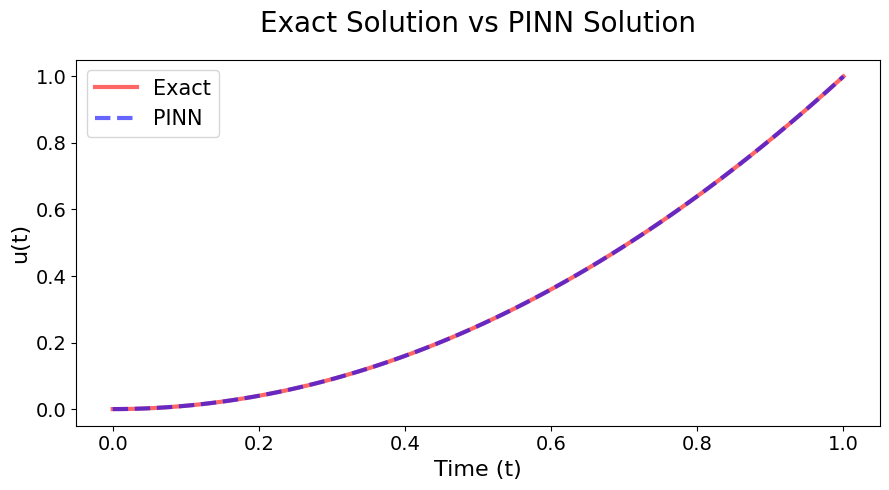

In [15]:
# 5. 시각화 및 평가 (글자 크기 확대 버전)
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)
y_exact = exact_sol(x_test).to('cpu')
y_pinn = model(x_test).detach().to('cpu')

plt.figure(figsize=(9, 5)) # 그래프 크기도 조금 더 키우는 것이 좋습니다.

# 데이터 플롯
plt.plot(x_test.cpu().numpy(), y_exact.numpy(), 'r', label='Exact', linewidth=3, alpha=0.6)
plt.plot(x_test.cpu().numpy(), y_pinn.numpy(), 'b--', label='PINN', linewidth=3, alpha=0.6)

# 글자 크기 설정
plt.title("Exact Solution vs PINN Solution", fontsize=20, pad=20)
plt.xlabel("Time (t)", fontsize=16)
plt.ylabel("u(t)", fontsize=16)

# 축 숫자(Tick) 크기 조절
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 크기 조절
plt.legend(fontsize=15, loc='upper left')

plt.tight_layout()
plt.show()